Moment:   0%|          | 0/6435 [00:00<?, ?it/s]

MLE:   0%|          | 0/6435 [00:00<?, ?it/s]

Kernel reflect:   0%|          | 0/6435 [00:00<?, ?it/s]

Moment: (0.9595180679107066, 0.9723262040929214)
MLE: (0.9519212662850784, 1.0070233076562265)


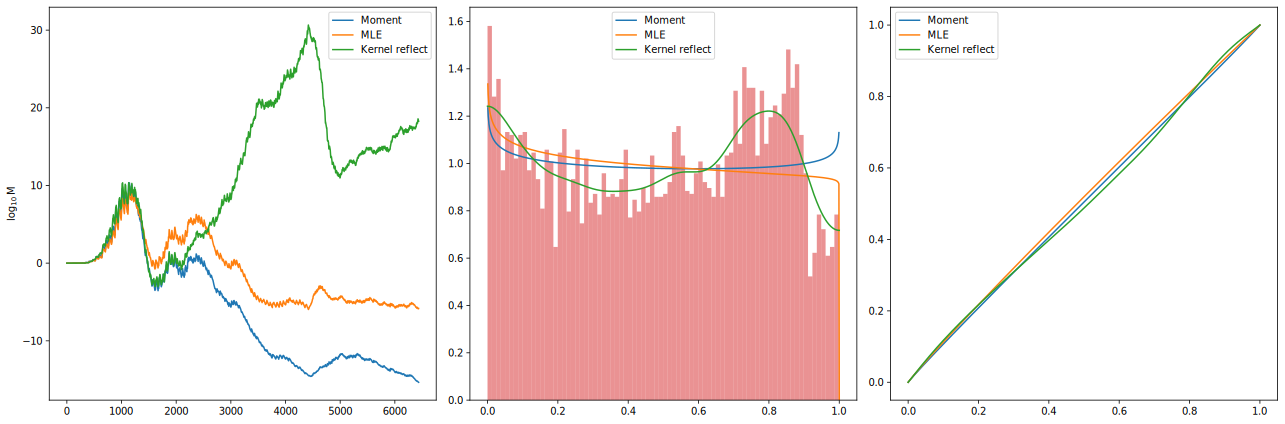

In [1]:
from online_cp import PluginMartingale
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
from matplotlib_inline.backend_inline import set_matplotlib_formats
# Set the desired output format
set_matplotlib_formats('svg')
from tqdm.notebook import tqdm
from scipy.stats import beta

min_sample_size = 1000
mixing_exponent = 3

martingale_mom = PluginMartingale(method='beta', beta_method='moment', min_sample_size=min_sample_size, mixing_exponent=mixing_exponent, warnings=False)
martingale_mle = PluginMartingale(method='beta', beta_method='mle', min_sample_size=min_sample_size, mixing_exponent=mixing_exponent, warnings=False)

bandwidth='silverman'
martingale_gaussian_kernel_reflect = PluginMartingale(method='kernel', kernel_method='reflect', min_sample_size=min_sample_size, mixing_exponent=mixing_exponent, bandwidth=bandwidth, warnings=False)
martingale_gaussian_kernel_logit = PluginMartingale(method='kernel', kernel_method='logit', edge_adjustment=0.001, min_sample_size_kernel=min_sample_size, mixing_exponent=mixing_exponent, bandwidth=bandwidth, warnings=False)


p_values = np.load('data_martingale_experiment/p_values_satelite_orig.npy')
N = len(p_values)

# a = 0.8
# b = 3
# # np.random.seed(2024)
# N = 1000
# p_values = np.random.beta(a, b, size=N)

mom_protection = []
mle_protection = []
reflect_protection = []
logit_protection = []

for p in tqdm(p_values, desc='Moment'):
    martingale_mom.update_martingale_value(p)
    mom_protection.append(martingale_mom.B_n(p))
for p in tqdm(p_values, desc='MLE'):
    martingale_mle.update_martingale_value(p)
    mle_protection.append(martingale_mle.B_n(p))
for p in tqdm(p_values, desc='Kernel reflect'):
    martingale_gaussian_kernel_reflect.update_martingale_value(p)
    reflect_protection.append(martingale_gaussian_kernel_reflect.B_n(p))
# for p in tqdm(p_values, desc='Kernel logit'):
#     martingale_gaussian_kernel_logit.update_martingale_value(p)
#     logit_protection.append(martingale_gaussian_kernel_logit.B_n(p))

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18,6))
axs[0].plot(martingale_mom.log10_martingale_values, label='Moment')
axs[0].plot(martingale_mle.log10_martingale_values, label='MLE')
axs[0].plot(martingale_gaussian_kernel_reflect.log10_martingale_values, label='Kernel reflect')
# axs[0].plot(martingale_gaussian_kernel_logit.log10_martingale_values, label='Kernel logit')

axs[0].set_ylabel(r'$\log_{10}M$')
axs[0].legend()

prange = np.linspace(0, 1, num=1000)
axs[1].plot(
    prange,
    martingale_mom.b_n(prange),
    label='Moment'
)
axs[1].plot(
    prange,
    martingale_mle.b_n(prange),
    label='MLE'
)
axs[1].plot(
    prange,
    martingale_gaussian_kernel_reflect.b_n(prange),
    label='Kernel reflect'
)
# axs[1].plot(
#     prange,
#     martingale_gaussian_kernel_logit.b_n(prange),
#     label='Kernel logit'
# )
# axs[1].plot(prange, beta.pdf(prange, a, b), label='True PDF', color='red', linestyle='--')
axs[1].hist(p_values, density=True, alpha=0.5, bins=int(np.sqrt(N)))
axs[1].legend()

axs[2].plot(
    prange,
    martingale_mom.B_n(prange),
    label='Moment'
)
axs[2].plot(
    prange,
    martingale_mle.B_n(prange),
    label='MLE'
)
axs[2].plot(
    prange,
    martingale_gaussian_kernel_reflect.B_n(prange),
    label='Kernel reflect'
)
# axs[2].plot(
#     prange,
#     martingale_gaussian_kernel_logit.B_n(prange),
#     label='Kernel logit'
# )
# axs[2].plot(prange, beta.cdf(prange, a, b), label='True CDF', color='red', linestyle='--')
axs[2].legend()
fig.tight_layout()

print(f'Moment: {martingale_mom.ahat, martingale_mom.bhat}')
print(f'MLE: {martingale_mle.ahat, martingale_mle.bhat}')

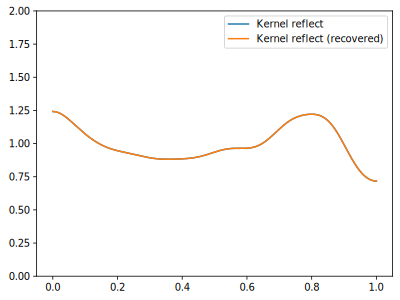

In [2]:
b = lambda x: (martingale_gaussian_kernel_reflect.mixing_parameter - 1 + martingale_gaussian_kernel_reflect.b_n(x))/martingale_gaussian_kernel_reflect.mixing_parameter
plt.plot(
    prange,
    martingale_gaussian_kernel_reflect.b_n(prange),
    label='Kernel reflect'
)
plt.plot(
    prange,
    b(prange),
    label='Kernel reflect (recovered)'
)
plt.ylim(0,2)
plt.legend()

For the USPS dataset, the Gaussian kernel with logit transform fails to reject exchangeability. This is suspect...

# Generate p-values wiht a known (non-beta) distribution and bet optimally. Can we push them to uniformity?
Use scipy custom random variable with some wierd density.

In [3]:
# TODO Perform the experiment

# Check derivatives

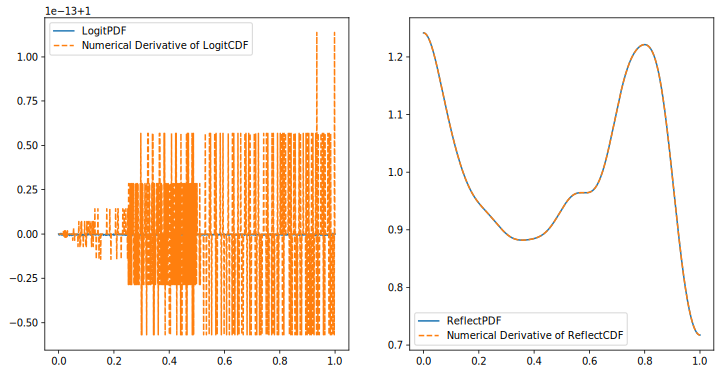

In [4]:
cdf_logit_vals = [martingale_gaussian_kernel_logit.B_n(p) for p in prange]
numerical_pdf_logit = np.gradient(cdf_logit_vals, prange)

pdf_reflect_vals = [martingale_gaussian_kernel_reflect.B_n(p) for p in prange]
numerical_pdf_reflect = np.gradient(pdf_reflect_vals, prange)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
axs[0].plot(prange, [martingale_gaussian_kernel_logit.b_n(p) for p in prange], label='LogitPDF')
axs[0].plot(prange, numerical_pdf_logit, label="Numerical Derivative of LogitCDF", linestyle='--')
axs[0].legend()

axs[1].plot(prange, [martingale_gaussian_kernel_reflect.b_n(p) for p in prange], label='ReflectPDF')
axs[1].plot(prange, numerical_pdf_reflect, label="Numerical Derivative of ReflectCDF", linestyle='--')
axs[1].legend()

# Check protection

Moment:   0%|          | 0/6435 [00:00<?, ?it/s]

MLE:   0%|          | 0/6435 [00:00<?, ?it/s]

Kernel reflect:   0%|          | 0/6435 [00:00<?, ?it/s]

Kernel logit:   0%|          | 0/6435 [00:00<?, ?it/s]

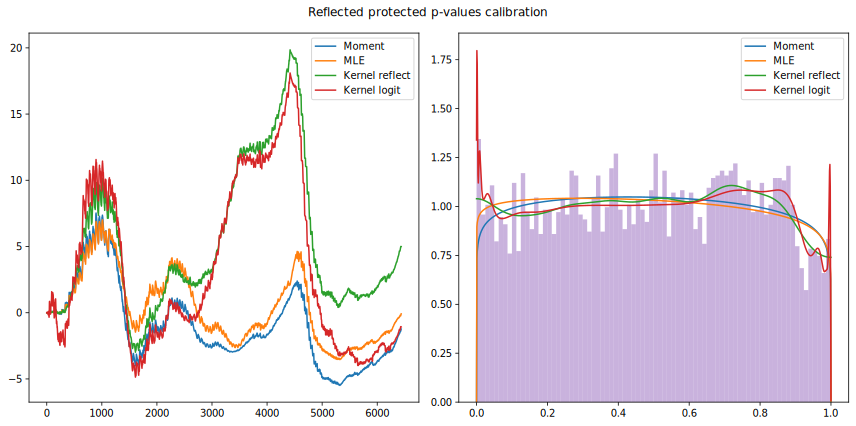

In [5]:
martingale_mom = PluginMartingale(method='beta', beta_method='moment', min_sample_size=min_sample_size, warnings=False)
martingale_mle = PluginMartingale(method='beta', beta_method='mle', min_sample_size=min_sample_size, warnings=False)

bandwidth='silverman'
martingale_gaussian_kernel_reflect = PluginMartingale(method='kernel', kernel_method='reflect', min_sample_size=min_sample_size, bandwidth=bandwidth, warnings=False)
martingale_gaussian_kernel_logit = PluginMartingale(method='kernel', kernel_method='logit', edge_adjustment=0.001, min_sample_size_kernel=min_sample_size, bandwidth=bandwidth, warnings=False)

P = reflect_protection

for p in tqdm(P, desc='Moment'):
    martingale_mom.update_martingale_value(p)
for p in tqdm(P, desc='MLE'):
    martingale_mle.update_martingale_value(p)
for p in tqdm(P, desc='Kernel reflect'):
    martingale_gaussian_kernel_reflect.update_martingale_value(p)
for p in tqdm(P, desc='Kernel logit'):
    martingale_gaussian_kernel_logit.update_martingale_value(p)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
fig.suptitle('Reflected protected p-values calibration')
axs[0].plot(martingale_mom.log10_martingale_values, label='Moment')
axs[0].plot(martingale_mle.log10_martingale_values, label='MLE')
axs[0].plot(martingale_gaussian_kernel_reflect.log10_martingale_values, label='Kernel reflect')
axs[0].plot(martingale_gaussian_kernel_logit.log10_martingale_values, label='Kernel logit')
axs[0].legend()
prange = np.linspace(0, 1, num=1000)
axs[1].plot(
    prange,
    martingale_mom.b_n(prange),
    label='Moment'
)
axs[1].plot(
    prange,
    martingale_mle.b_n(prange),
    label='MLE'
)
axs[1].plot(
    prange,
    martingale_gaussian_kernel_reflect.b_n(prange),
    label='Kernel reflect'
)
axs[1].plot(
    prange,
    martingale_gaussian_kernel_logit.b_n(prange),
    label='Kernel logit'
)
axs[1].hist(P, density=True, alpha=0.5, bins=int(np.sqrt(N)))
axs[1].legend()
fig.tight_layout()

Moment: 0it [00:00, ?it/s]

MLE: 0it [00:00, ?it/s]

Kernel reflect: 0it [00:00, ?it/s]

Kernel logit: 0it [00:00, ?it/s]

/home/joha5534/.conda/envs/online-cp/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


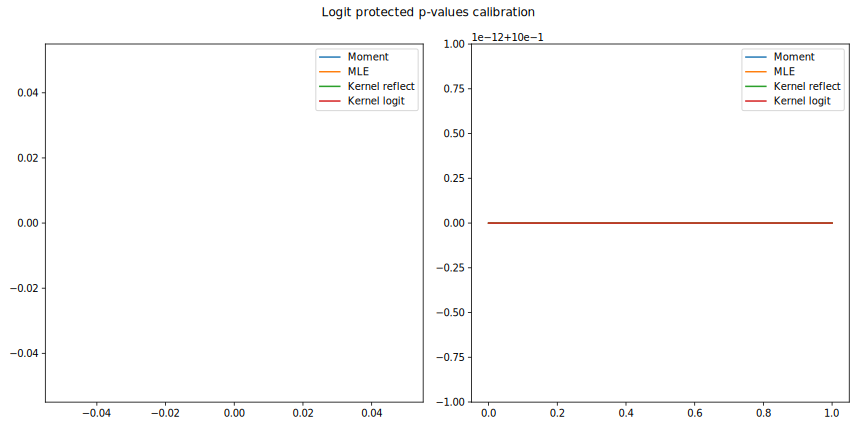

In [6]:
martingale_mom = PluginMartingale(method='beta', beta_method='moment', min_sample_size=min_sample_size, warnings=False)
martingale_mle = PluginMartingale(method='beta', beta_method='mle', min_sample_size=min_sample_size, warnings=False)

bandwidth='silverman'
martingale_gaussian_kernel_reflect = PluginMartingale(method='kernel', kernel_method='reflect', min_sample_size=min_sample_size, bandwidth=bandwidth, warnings=False)
martingale_gaussian_kernel_logit = PluginMartingale(method='kernel', kernel_method='logit', edge_adjustment=0.001, min_sample_size_kernel=min_sample_size, bandwidth=bandwidth, warnings=False)

P = logit_protection

for p in tqdm(P, desc='Moment'):
    martingale_mom.update_martingale_value(p)
for p in tqdm(P, desc='MLE'):
    martingale_mle.update_martingale_value(p)
for p in tqdm(P, desc='Kernel reflect'):
    martingale_gaussian_kernel_reflect.update_martingale_value(p)
for p in tqdm(P, desc='Kernel logit'):
    martingale_gaussian_kernel_logit.update_martingale_value(p)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
fig.suptitle('Logit protected p-values calibration')
axs[0].plot(martingale_mom.log10_martingale_values, label='Moment')
axs[0].plot(martingale_mle.log10_martingale_values, label='MLE')
axs[0].plot(martingale_gaussian_kernel_reflect.log10_martingale_values, label='Kernel reflect')
axs[0].plot(martingale_gaussian_kernel_logit.log10_martingale_values, label='Kernel logit')
axs[0].legend()
prange = np.linspace(0, 1, num=1000)
axs[1].plot(
    prange,
    martingale_mom.b_n(prange),
    label='Moment'
)
axs[1].plot(
    prange,
    martingale_mle.b_n(prange),
    label='MLE'
)
axs[1].plot(
    prange,
    martingale_gaussian_kernel_reflect.b_n(prange),
    label='Kernel reflect'
)
axs[1].plot(
    prange,
    martingale_gaussian_kernel_logit.b_n(prange),
    label='Kernel logit'
)
axs[1].hist(P, density=True, alpha=0.5, bins=int(np.sqrt(N)))
axs[1].legend()
fig.tight_layout()

Moment:   0%|          | 0/6435 [00:00<?, ?it/s]

MLE:   0%|          | 0/6435 [00:00<?, ?it/s]

Kernel reflect:   0%|          | 0/6435 [00:00<?, ?it/s]

Kernel logit:   0%|          | 0/6435 [00:00<?, ?it/s]

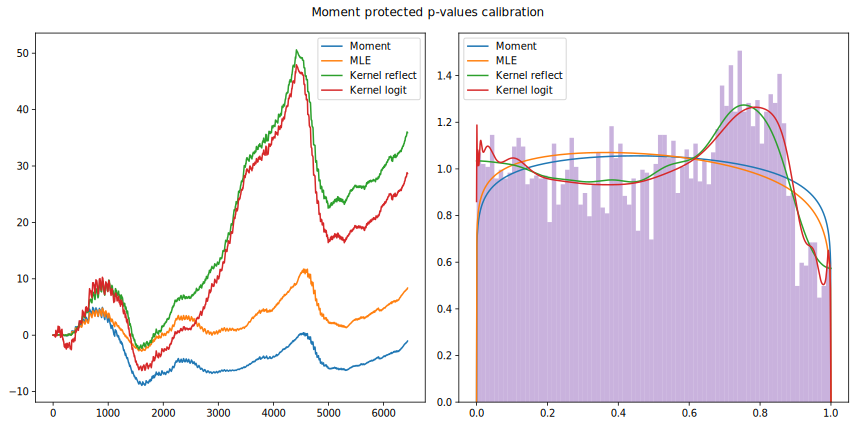

In [7]:
martingale_mom = PluginMartingale(method='beta', beta_method='moment', min_sample_size=min_sample_size, warnings=False)
martingale_mle = PluginMartingale(method='beta', beta_method='mle', min_sample_size=min_sample_size, warnings=False)

bandwidth='silverman'
martingale_gaussian_kernel_reflect = PluginMartingale(method='kernel', kernel_method='reflect', min_sample_size=min_sample_size, bandwidth=bandwidth, warnings=False)
martingale_gaussian_kernel_logit = PluginMartingale(method='kernel', kernel_method='logit', edge_adjustment=0.001, min_sample_size_kernel=min_sample_size, bandwidth=bandwidth, warnings=False)

P = mom_protection

for p in tqdm(P, desc='Moment'):
    martingale_mom.update_martingale_value(p)
for p in tqdm(P, desc='MLE'):
    martingale_mle.update_martingale_value(p)
for p in tqdm(P, desc='Kernel reflect'):
    martingale_gaussian_kernel_reflect.update_martingale_value(p)
for p in tqdm(P, desc='Kernel logit'):
    martingale_gaussian_kernel_logit.update_martingale_value(p)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
fig.suptitle('Moment protected p-values calibration')
axs[0].plot(martingale_mom.log10_martingale_values, label='Moment')
axs[0].plot(martingale_mle.log10_martingale_values, label='MLE')
axs[0].plot(martingale_gaussian_kernel_reflect.log10_martingale_values, label='Kernel reflect')
axs[0].plot(martingale_gaussian_kernel_logit.log10_martingale_values, label='Kernel logit')
axs[0].legend()
prange = np.linspace(0, 1, num=1000)
axs[1].plot(
    prange,
    martingale_mom.b_n(prange),
    label='Moment'
)
axs[1].plot(
    prange,
    martingale_mle.b_n(prange),
    label='MLE'
)
axs[1].plot(
    prange,
    martingale_gaussian_kernel_reflect.b_n(prange),
    label='Kernel reflect'
)
axs[1].plot(
    prange,
    martingale_gaussian_kernel_logit.b_n(prange),
    label='Kernel logit'
)
axs[1].hist(P, density=True, alpha=0.5, bins=int(np.sqrt(N)))
axs[1].legend()
fig.tight_layout()

Moment:   0%|          | 0/6435 [00:00<?, ?it/s]

MLE:   0%|          | 0/6435 [00:00<?, ?it/s]

Kernel reflect:   0%|          | 0/6435 [00:00<?, ?it/s]

Kernel logit:   0%|          | 0/6435 [00:00<?, ?it/s]

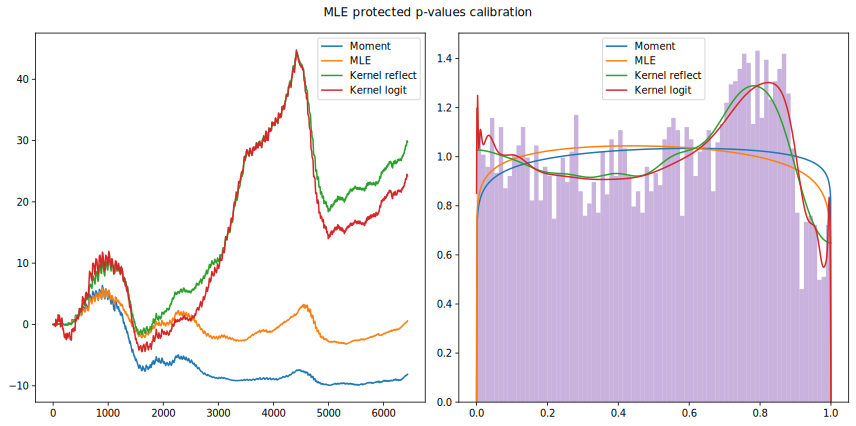

In [8]:
martingale_mom = PluginMartingale(method='beta', beta_method='moment', min_sample_size=min_sample_size, warnings=False)
martingale_mle = PluginMartingale(method='beta', beta_method='mle', min_sample_size=min_sample_size, warnings=False)

bandwidth='silverman'
martingale_gaussian_kernel_reflect = PluginMartingale(method='kernel', kernel_method='reflect', min_sample_size=min_sample_size, bandwidth=bandwidth, warnings=False)
martingale_gaussian_kernel_logit = PluginMartingale(method='kernel', kernel_method='logit', edge_adjustment=0.001, min_sample_size_kernel=min_sample_size, bandwidth=bandwidth, warnings=False)

P = mle_protection

for p in tqdm(P, desc='Moment'):
    martingale_mom.update_martingale_value(p)
for p in tqdm(P, desc='MLE'):
    martingale_mle.update_martingale_value(p)
for p in tqdm(P, desc='Kernel reflect'):
    martingale_gaussian_kernel_reflect.update_martingale_value(p)
for p in tqdm(P, desc='Kernel logit'):
    martingale_gaussian_kernel_logit.update_martingale_value(p)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
fig.suptitle('MLE protected p-values calibration')
axs[0].plot(martingale_mom.log10_martingale_values, label='Moment')
axs[0].plot(martingale_mle.log10_martingale_values, label='MLE')
axs[0].plot(martingale_gaussian_kernel_reflect.log10_martingale_values, label='Kernel reflect')
axs[0].plot(martingale_gaussian_kernel_logit.log10_martingale_values, label='Kernel logit')
axs[0].legend()
prange = np.linspace(0, 1, num=1000)
axs[1].plot(
    prange,
    martingale_mom.b_n(prange),
    label='Moment'
)
axs[1].plot(
    prange,
    martingale_mle.b_n(prange),
    label='MLE'
)
axs[1].plot(
    prange,
    martingale_gaussian_kernel_reflect.b_n(prange),
    label='Kernel reflect'
)
axs[1].plot(
    prange,
    martingale_gaussian_kernel_logit.b_n(prange),
    label='Kernel logit'
)
axs[1].hist(P, density=True, alpha=0.5, bins=int(np.sqrt(N)))
axs[1].legend()
fig.tight_layout()